# Keras tutorial - Emotion Detection in Images of Faces

Welcome to the first assignment of week 2. In this assignment, you will:
1. Learn to use Keras, a high-level neural networks API (programming framework), written in Python and capable of running on top of several lower-level frameworks including TensorFlow and CNTK. 
2. See how you can in a couple of hours build a deep learning algorithm.

#### Why are we using Keras? 

* Keras was developed to enable deep learning engineers to build and experiment with different models very quickly. 
* Just as TensorFlow is a higher-level framework than Python, Keras is an even higher-level framework and provides additional abstractions. 
* Being able to go from idea to result with the least possible delay is key to finding good models. 
* However, Keras is more restrictive than the lower-level frameworks, so there are some very complex models that you would still implement in TensorFlow rather than in Keras. 
* That being said, Keras will work fine for many common models. 

## Load packages
* In this exercise, you'll work on the "Emotion detection" model, which we'll explain below. 
* Let's load the required packages.

In [0]:
import keras.backend as K
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt


def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def load_dataset():
    train_dataset = h5py.File('train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes



In [0]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

## 1 - Emotion Tracking

* A nearby community health clinic is helping the local residents monitor their mental health.  
* As part of their study, they are asking volunteers to record their emotions throughout the day.
* To help the participants more easily track their emotions, you are asked to create an app that will classify their emotions based on some pictures that the volunteers will take of their facial expressions.
* As a proof-of-concept, you first train your model to detect if someone's emotion is classified as "happy" or "not happy."

To build and train this model, you have gathered pictures of some volunteers in a nearby neighborhood. The dataset is labeled.

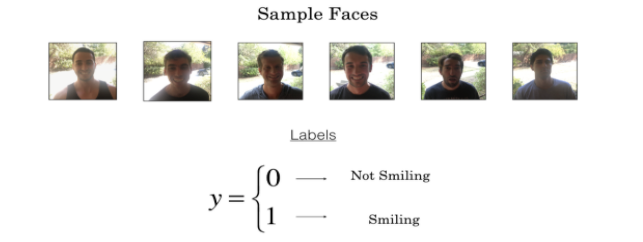

Run the following code to normalize the dataset and learn about its shapes.

In [16]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


**Details of the "Face" dataset**:
- Images are of shape (64,64,3)
- Training: 600 pictures
- Test: 150 pictures

## 2 - Building a model in Keras

Keras is very good for rapid prototyping. In just a short time you will be able to build a model that achieves outstanding results.

Here is an example of a model in Keras:

```python
def model(input_shape):
    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model
```

#### Variable naming convention

* Note that Keras uses a different convention with variable names than we've previously used with numpy and TensorFlow. 
* Instead of creating unique variable names for each step and each layer, such as 
```
X = ...
Z1 = ...
A1 = ...
```
* Keras re-uses and overwrites the same variable at each step:
```
X = ...
X = ...
X = ...
```
* The exception is `X_input`, which we kept separate since it's needed later.

#### Objects as functions
* Notice how there are two pairs of parentheses in each statement.  For example:
```
X = ZeroPadding2D((3, 3))(X_input)
```
* The first is a constructor call which creates an object (ZeroPadding2D).
* In Python, objects can be called as functions. Search for 'python object as function and you can read this blog post [Python Pandemonium](https://medium.com/python-pandemonium/function-as-objects-in-python-d5215e6d1b0d).  See the section titled "Objects as functions."
* The single line is equivalent to this:
```
ZP = ZeroPadding2D((3, 3)) # ZP is an object that can be called as a function
X = ZP(X_input) 
```

In [0]:
def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    ### START CODE HERE ###
    # Feel free to use the suggested outline in the text above to get started, and run through the whole
    # exercise (including the later portions of this notebook) once. The come back also try out other
    # network architectures as well. 
    X_input = Input(input_shape)
    
    # Zero padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # CONV -> BN -> RELU
    X = Conv2D(32, (7, 7), strides = (1, 1), name='conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    # MAX-POOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)
    
    # Flatten
    X = Flatten()(X)
    X = Dense(1, activation = 'sigmoid', name='fc')(X)
    
    # create model
    model = Model(inputs = X_input, outputs = X, name = 'HappyModel')
    
    ### END CODE HERE ###
    
    return model

You have now built a function to describe your model. To train and test this model, there are four steps in Keras:
1. Create the model by calling the function above  

2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`  

3. Train the model on train data by calling `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`  

4. Test the model on test data by calling `model.evaluate(x = ..., y = ...)`  

If you want to know more about `model.compile()`, `model.fit()`, `model.evaluate()` and their arguments, refer to the official [Keras documentation](https://keras.io/models/model/).

#### Step 1: create the model.  
**Hint**:  
The `input_shape` parameter is a tuple (height, width, channels).  It excludes the batch number.  
Try `X_train.shape[1:]` as the `input_shape`.

In [0]:
happyModel = HappyModel((64, 64, 3))

Exercise: Implement step 2, i.e. compile the model to configure the learning process. Choose the 3 arguments of compile() wisely. Hint: the Happy Challenge is a binary classification problem.


In [0]:
happyModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


Exercise: Implement step 3, i.e. train the model. Choose the number of epochs and the batch size.



In [20]:
happyModel.fit(x = X_train, y = Y_train, epochs = 40, batch_size = 32)


Epoch 1/40
600/600 [==============================] - 4s 7ms/step - loss: 1.9123 - accuracy: 0.5950
Epoch 2/40
600/600 [==============================] - 4s 6ms/step - loss: 0.3367 - accuracy: 0.8450
Epoch 3/40
600/600 [==============================] - 4s 6ms/step - loss: 0.2089 - accuracy: 0.9250
Epoch 4/40
600/600 [==============================] - 4s 6ms/step - loss: 0.1736 - accuracy: 0.9283
Epoch 5/40
600/600 [==============================] - 4s 6ms/step - loss: 0.1172 - accuracy: 0.9617
Epoch 6/40
600/600 [==============================] - 4s 6ms/step - loss: 0.0917 - accuracy: 0.9700
Epoch 7/40
600/600 [==============================] - 4s 6ms/step - loss: 0.0731 - accuracy: 0.9850
Epoch 8/40
600/600 [==============================] - 4s 6ms/step - loss: 0.1088 - accuracy: 0.9633
Epoch 9/40
600/600 [==============================] - 4s 7ms/step - loss: 0.1088 - accuracy: 0.9600
Epoch 10/40
600/600 [==============================] - 4s 6ms/step - loss: 0.0595 - accuracy: 0.9833

In [21]:
preds = happyModel.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 0s 2ms/step

Loss = 0.16166163484255472
Test Accuracy = 0.9200000166893005


#### Tips for improving your model

If you have not yet achieved a very good accuracy (>= 80%), here are some things tips:

- Use blocks of CONV->BATCHNORM->RELU such as:
```python
X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
X = BatchNormalization(axis = 3, name = 'bn0')(X)
X = Activation('relu')(X)
```
until your height and width dimensions are quite low and your number of channels quite large (≈32 for example).  
You can then flatten the volume and use a fully-connected layer.
- Use MAXPOOL after such blocks.  It will help you lower the dimension in height and width.
- Change your optimizer. We find 'adam' works well. 
- If you get memory issues, lower your batch_size (e.g. 12 )
- Run more epochs until you see the train accuracy no longer improves. 

**Note**: If you perform hyperparameter tuning on your model, the test set actually becomes a dev set, and your model might end up overfitting to the test (dev) set. Normally, you'll want separate dev and test sets.  The dev set is used for parameter tuning, and the test set is used once to estimate the model's performance in production.